In [207]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
import matplotlib.ticker as mtick
from  itertools import product
import copy
# from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer



import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import keras
from tensorflow.python.keras import layers as layer_module
from tensorflow.python.keras.engine import base_layer
from tensorflow.python.keras.engine import base_layer_utils
from tensorflow.python.keras.engine import input_layer
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.engine import training_utils
from tensorflow.python.keras.saving.saved_model import model_serialization
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export
from sklearn.model_selection import train_test_split

**The objective of this project is to utilize Tensorflow to build a neural netowrk that will predict NHL players' salary. Along the way I'll be exploring what metrics tend to drive a player's salary as well as develope features of my own that I believe will have predictive value.**

https://www.kaggle.com/camnugent/predict-nhl-player-salaries

I used this dataset to obtain salary info for 874 NHL players from the 2016-2017 season, along with 151 predictor columns comprised of anything from  physial characteristics, shot statistcs (both individual and team while the palyer is on the ice), hits metrics, and so on.

In [129]:
test_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary test.csv', encoding = 'ISO-8859-1')
train_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary train.csv', encoding = 'ISO-8859-1')
salaries = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary test_salaries.csv', encoding = 'ISO-8859-1')

In [130]:
# The data came already split between test and training data, but I'm going to stack them so I can clean ande explore
# the data at once, then split it on my own later on

test_df['Salary'] = salaries['Salary']

df = train_df.append(test_df, sort = False)
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)

df
# df.to_clipboard(excel = True)

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,632500.0,97-03-11,Kingston,ON,CAN,CAN,74,219,2011.0,2.0,...,9.0,0.1,0.8,0.9,858.75,55,6.3,105.3,2.6,0.12
870,600000.0,95-01-30,Denver,CO,USA,USA,75,205,2009.0,2.0,...,5.0,-0.2,0.1,-0.1,588.65,29,13.0,99.6,0.4,0.03
871,5500000.0,97-06-18,Toronto,ON,CAN,CAN,78,210,2011.0,1.0,...,97.0,4.8,4.7,9.5,3133.83,226,2.7,113.6,65.1,0.80
872,832500.0,98-09-21,Hilton Head Isl.,SC,USA,USA,72,181,2013.0,1.0,...,59.0,2.8,1.4,4.2,3076.20,223,7.9,110.8,43.4,0.57


**Exploratory Data Analysis**

In [131]:
# Start of season is Oct 12, 2016
def elapsed_days(start, end=datetime(2016,10,12)):
    """ calcualte the number of days start and end dates"""
    x = (end - start)/365.25
    return x.days

# Get ages for season
df['AgeStart'] = df.apply(lambda x: elapsed_days(datetime.strptime(x['Born'], '%y-%m-%d')) ,axis=1)


# This player has a ton of missing info and only 1 game played
df = df[df['Last Name'] != 'Renouf']

# Drop columns that are of no use or redundant
# drop_cols = ['City', 'Pr/St', 'Cntry', 'Last Name', 'First Name', 'Team', 'Born']
drop_cols = ['City', 'Pr/St', 'Cntry']
drop_cols2 = ['Position', 'Last Name', 'First Name', 'Team']
# I'll drop name, position, and team later, but I'll keep them in for now to help with the EDA process
df.drop(drop_cols, axis = 1, inplace = True)


# Two average shot distance measures. Not sure what the difference is
# but one is non-numeric and has missing values so I dropeed it
df.drop('sDist.1', axis = 1, inplace = True)


# Tensorflor doesn't seem to like symbols in column names
df.columns = df.columns.str.replace('/', '')
df.columns = df.columns.str.replace('+', 'pls')
df.columns = df.columns.str.replace('-', 'min')
df.columns = df.columns.str.replace('%', 'perc')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace(' ', '')


# # Parse players with multiple positions and pivot
df['Position'] = df['Position'].apply(lambda x: x.split('/') if isinstance (x, str) else [x])
s = df['Position']
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
df = df.join(dummies)


# I'll drop position and team later, but I'll keep them in for now to help with the EDA process
# df.drop('Position', axis = 1, inplace = True)

# Create lastname_firstname field
df['last_first'] = df['LastName'] + '_' + df['FirstName']
drop_cols2 = drop_cols2.append('last_first')

df.to_clipboard(excel = True)

C:\Users\Pat\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [132]:
# Missing values
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(20)

,Total,Percent
Ovrl,124,0.142039
DftYr,124,0.142039
DftRd,124,0.142039
iCF,10,0.011455
iFF,10,0.011455
iRB,10,0.011455
iDS,10,0.011455
iHA,10,0.011455
iHDf,10,0.011455
iSF,10,0.011455


The missing values in the first three columns all indicate the player was undrafted, so I'll go ahead and fill that in then deal with the rest.

In [133]:
draft = ['Ovrl', 'DftYr','DftRd']

for i in draft:
    df[i].fillna('Undrafted', inplace = True)

In [134]:
# Missing values
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(20)

,Total,Percent
iCF,10,0.011455
iFF,10,0.011455
iRB,10,0.011455
iDS,10,0.011455
iHA,10,0.011455
iHDf,10,0.011455
iSF,10,0.011455
PDO,1,0.001145
Pass,1,0.001145
GSG,1,0.001145


In [135]:
df2 = df.copy()
df2.drop(['DftYr', 'DftRd', 'Ovrl'], axis = 1, inplace = True)
df3 = df2[df2.isnull().any(axis=1)]
df3.reset_index()


print('Players with missing data')
df3

Players with missing data


,Salary,Born,Nat,Ht,Wt,Hand,LastName,FirstName,Position,Team,...,DAP,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first
20,5000000.0,94-03-09,CAN,73,215,L,Rielly,Morgan,[D],TOR,...,10.0,122.4,34.9,0.46,22,0,1,0,0,Rielly_Morgan
22,925000.0,96-05-01,SWE,72,190,R,Nylander,William,"[C, RW]",TOR,...,5.3,121.6,61.0,0.75,20,1,0,0,1,Nylander_William
25,925000.0,96-05-25,CZE,72,181,R,Pastrnak,David,"[RW, LW]",BOS,...,7.2,120.0,89.4,1.19,20,0,0,1,1,Pastrnak_David
114,925000.0,97-09-17,USA,75,216,L,Matthews,Auston,[C],TOR,...,16.2,122.4,77.9,0.95,19,1,0,0,0,Matthews_Auston
141,892500.0,91-12-01,USA,70,208,R,Acciari,Noel,[C],BOS,...,30.0,96.4,4.8,0.17,24,1,0,0,0,Acciari_Noel
178,875000.0,94-11-09,USA,76,203,L,Sanford,Zach,[LW],STL/WSH,...,7.2,103.3,6.7,NaN,21,0,0,1,0,Sanford_Zach
199,635000.0,93-02-26,CAN,74,215,L,Goodrow,Barclay,"[RW, C]",S.J,...,0.0,93.8,0.3,0.09,23,1,0,0,1,Goodrow_Barclay
231,900000.0,89-05-09,CAN,73,200,R,Nash,Riley,"[C, RW]",BOS,...,16.4,102.9,25.5,0.31,27,1,0,0,1,Nash_Riley
248,6000000.0,89-03-28,CAN,73,200,L,Couture,Logan,"[C, LW]",S.J,...,19.2,120.8,53.4,0.73,27,1,0,1,0,Couture_Logan
291,900000.0,92-10-29,CAN,73,196,R,Miller,Colin,[D],BOS,...,6.9,108.0,31.9,0.52,23,0,1,0,0,Miller_Colin


**You might be saying "But wait a minute Pat, David Krecji was definitely born before 1990. And James van Riemsdyk was for sure born before 1993." I noticed that too, and you're absolutely right. Looking into it further, the birthday for every player I spot checked in the original test data (before I stacked them above) was off by exactly four years. I have no clue why, but I posted a discussion on the Kaggle page to bring it to people's attention. Having as many as 262 players with ages off by 4 years seems like a pretty big deal to me. You'd expect a pretty significant dropoff in production from the ages of 31 to 35. On the flip-side, you'd typically expect a good deal more out of a palyer when he's 25 as opposed to when he's 21 and still finding his way in the league. Thus, I'll look elsewhere to solve this issue**

**I was already toying with the idea of finding a dataset to help fill in the missing records above. I could do this either by directly calculating the missing fields for these players with the new data, or perhaps use the data to help find comparable players (over a longer, more stable window) and then use these players' data to fill in the missing values**

**I found a dataset that should be of help, and it also happens to have a date of birth that seems more reliable (I haven't found any errors with some spot checking) than the one we have now. Bringing in some longer term performance metrics should hopefully add value as features for my model here as well. Three birds with one dataset!**

**Let's put a bookmark on these players with missing data. We'll bring in all this data and get back to it later.**


https://www.kaggle.com/martinellis/nhl-game-data

There's a bunch of fun data to work with here at various levels of granularity. Player info, game data, play by play statistics etc.

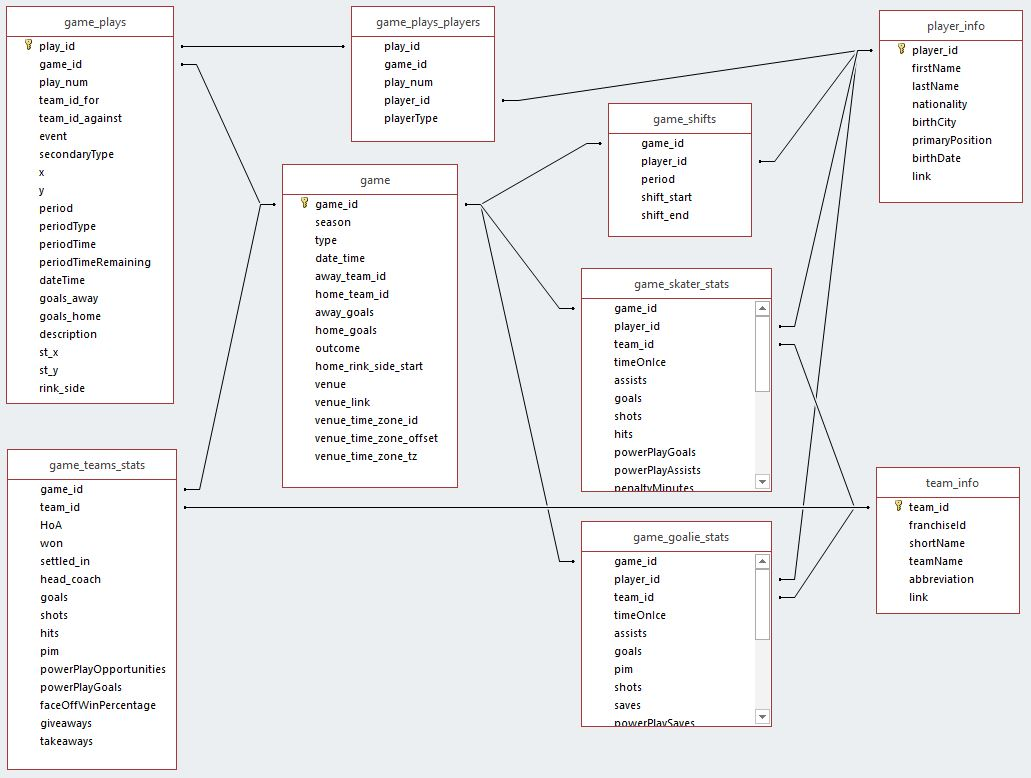

In [136]:
game0_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\game_skater_stats.csv')
player_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\player_info.csv')
game_info_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\game.csv')
player_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\player_info.csv')
# shots_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\Denormalized Shots with Passes.csv')

game1_df = pd.merge(game_info_df[['game_id', 'season', 'type', 'date_time']], game0_df, on='game_id')
game2_df = pd.merge(player_df[['player_id', 'birthDate', 'firstName', 'lastName']], game1_df, on='player_id')


# Creating an Age column
game2_df['age'] = ((pd.to_datetime(game2_df['date_time']) - 
             pd.to_datetime(game2_df['birthDate'])).dt.days / 365.25).astype(float)

game2_df['age_rounded'] = ((pd.to_datetime(game2_df['date_time']) - 
             pd.to_datetime(game2_df['birthDate'])).dt.days / 365.25).astype(int)


# Here I'm making a field for the age at the start of the season. Or more precisely, the age for each
# players' first game of the season
min_age_df = game2_df.groupby(['season', 'player_id'], as_index=False)['age_rounded'].min().reset_index().rename(columns={'age_rounded':'age_start'})


# Converting time on ice columns from seconds to minutes
game_df = pd.merge(min_age_df, game2_df, on=['player_id', 'season'])
game_df['timeOnIce'] = game_df['timeOnIce']/60
game_df['evenTimeOnIce'] = game_df['evenTimeOnIce']/60
game_df['shortHandedTimeOnIce'] = game_df['shortHandedTimeOnIce']/60
game_df['powerPlayTimeOnIce'] = game_df['powerPlayTimeOnIce']/60
agg_col = ['goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']
game_df['points'] = game_df['goals'] + game_df['assists']
# Get different levels of granularity

In [137]:
# Here I'm aggregating the game statistcs by player + season, player, season, age and season, and by age

# Player by season
pseason_df = game_df[['player_id', 'firstName', 'lastName', 'age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName', 'season', 'age_start']).sum().reset_index()
# Player total
p_df = game_df[['player_id', 'firstName', 'lastName', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName']).sum().reset_index()
# By Season
season_df = game_df[['season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['season']).sum().reset_index()
# By age and season
age_season_df = game_df[['age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start', 'season']).sum().reset_index()
# By age
age_df = game_df[['age_start', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start']).sum().reset_index()


# Here I'm creating fields for both goals and points per 60 minutes of playing time

# Get goals + points per 60 for each df
pseason_df['goals_60'] = (pseason_df['goals'] / pseason_df['timeOnIce'])*60
pseason_df['points_60'] = (pseason_df['points'] / pseason_df['timeOnIce'])*60
p_df['goals_60'] = (p_df['goals'] / p_df['timeOnIce'])*60
p_df['points_60'] = (p_df['points'] / p_df['timeOnIce'])*60
season_df['goals_60'] = (season_df['goals'] / season_df['timeOnIce'])*60
season_df['points_60'] = (season_df['points'] / season_df['timeOnIce'])*60
age_df['goals_60'] = (age_df['goals'] / age_df['timeOnIce'])*60
age_df['points_60'] = (age_df['points'] / age_df['timeOnIce'])*60
age_season_df['goals_60'] = (age_season_df['goals'] / age_season_df['timeOnIce'])*60
age_season_df['points_60'] = (age_season_df['points'] / age_season_df['timeOnIce'])*60

game_df

,index,season,player_id,age_start,birthDate,firstName,lastName,game_id,type,date_time,...,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,age,age_rounded,points
0,0,20102011,8446485,39,1971-05-24,Kris,Draper,2010030243,P,2011-05-05,...,0,0,0,1,8.783333,0.100000,0.000000,39.947981,39,1
1,0,20102011,8446485,39,1971-05-24,Kris,Draper,2010030244,P,2011-05-06,...,0,0,1,-1,7.083333,0.000000,0.000000,39.950719,39,0
2,0,20102011,8446485,39,1971-05-24,Kris,Draper,2010030245,P,2011-05-09,...,0,0,0,-1,7.450000,0.000000,0.000000,39.958932,39,0
3,0,20102011,8446485,39,1971-05-24,Kris,Draper,2010030247,P,2011-05-13,...,0,0,0,0,7.933333,0.000000,0.216667,39.969884,39,0
4,0,20102011,8446485,39,1971-05-24,Kris,Draper,2010030171,P,2011-04-13,...,0,0,1,0,9.716667,1.800000,0.000000,39.887748,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411573,7990,20182019,8481477,23,1995-05-03,Nico,Sturm,2018021267,R,2019-04-07,...,0,0,0,0,11.416667,0.816667,0.000000,23.928816,23,0
411574,7991,20182019,8481479,23,1995-05-28,Brogan,Rafferty,2018021249,R,2019-04-05,...,0,0,0,-1,12.050000,0.000000,0.000000,23.854894,23,0
411575,7991,20182019,8481479,23,1995-05-28,Brogan,Rafferty,2018021258,R,2019-04-06,...,0,0,2,0,14.650000,0.000000,0.000000,23.857632,23,0
411576,7992,20182019,8481481,21,1997-12-13,Blake,Lizotte,2018021270,R,2019-04-07,...,0,0,1,-1,11.200000,0.000000,0.000000,21.314168,21,0


Ok I got a little sidetracked there, now let's get back to getting some correct birth dates. I'll bring the player_id field above into my salary table by joining the tables on a new field created by concatenating the first and last name fields. I know I can join using multiple fields and don't necessarily need to create a new one, but I feel like it will be easier for me to see if there are any players with the same first and last names with this new field, and thus would mess up my join (looking at you Islanders Sebastian Aho, though I'm not sure if you were in league yet in 16-17)

In [138]:
player_df['last_first'] = player_df['lastName'] + '_' + player_df['firstName']
player_df

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link,last_first
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,Ponikarovsky_Alexei
1,8468501,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501,Volchenkov_Anton
2,8459670,Kimmo,Timonen,FIN,Kuopio,D,1975-03-18,/api/v1/people/8459670,Timonen_Kimmo
3,8471233,Travis,Zajac,CAN,Winnipeg,C,1985-05-13,/api/v1/people/8471233,Zajac_Travis
4,8455710,Martin,Brodeur,CAN,Montreal,G,1972-05-06,/api/v1/people/8455710,Brodeur_Martin
...,...,...,...,...,...,...,...,...,...
2404,8478040,Austin,Poganski,USA,St. Cloud,RW,1996-02-16,/api/v1/people/8478040,Poganski_Austin
2405,8480011,Klim,Kostin,RUS,Penza,C,1999-05-05,/api/v1/people/8480011,Kostin_Klim
2406,8480384,Alexander,True,DNK,Kobenhavn,C,1997-07-17,/api/v1/people/8480384,True_Alexander
2407,8480021,Jack,Studnicka,CAN,Windsor,C,1999-02-18,/api/v1/people/8480021,Studnicka_Jack


In [139]:
df = pd.merge(df, player_df[['player_id', 'last_first']], on='last_first', how = 'left')
df

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id
0,925000.0,97-01-30,CAN,74,190,2015,1,18,L,Chabot,...,175.7,-0.4,-0.38,19,0,1,0,0,Chabot_Thomas,8478469.0
1,2250000.0,93-12-21,CAN,74,207,2012,1,15,R,Ceci,...,112.5,14.1,0.18,22,0,1,0,0,Ceci_Cody,8476879.0
2,8000000.0,88-04-16,USA,72,218,2006,1,7,R,Okposo,...,114.8,36.8,0.57,28,0,0,0,1,Okposo_Kyle,8473449.0
3,3500000.0,92-01-07,CAN,77,220,2010,1,3,R,Gudbranson,...,105.1,5.9,0.20,24,0,1,0,0,Gudbranson_Erik,8475790.0
4,1750000.0,94-03-29,CAN,76,217,2012,1,16,R,Wilson,...,99.5,21.8,0.27,22,0,0,0,1,Wilson_Tom,8476880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,632500.0,97-03-11,CAN,74,219,2011,2,54,L,Harrington,...,105.3,2.6,0.12,19,0,1,0,0,Harrington_Scott,8476449.0
871,600000.0,95-01-30,USA,75,205,2009,2,44,R,Shore,...,99.6,0.4,0.03,21,1,0,0,0,Shore_Drew,8475213.0
872,5500000.0,97-06-18,CAN,78,210,2011,1,9,R,Hamilton,...,113.6,65.1,0.80,19,0,1,0,0,Hamilton_Dougie,8476462.0
873,832500.0,98-09-21,USA,72,181,2013,1,30,R,Hartman,...,110.8,43.4,0.57,18,0,0,1,1,Hartman_Ryan,8477451.0


In [140]:
# Some players didn't get assigned a player_id. I'm assumine name abbreviations, spelling etc. are mostly the issue
missing_names = df[df['player_id'].isnull()]
missing_names

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id
45,925000.0,94-09-22,SWE,74,196,2013,1,14,L,Wennberg,...,108.0,54.1,0.68,22,1,0,0,0,Wennberg_Alex,NaN
59,925000.0,98-03-02,CAN,73,180,2016,1,8,R,Nylander,...,118.3,0.9,0.23,18,0,0,1,1,Nylander_Alex,NaN
94,600000.0,92-02-25,USA,68,165,2011,3,66,R,Tynan,...,114.9,0.2,0.06,24,1,0,0,1,Tynan_T.J.,NaN
121,3000000.0,81-04-11,CAN,73,197,Undrafted,Undrafted,Undrafted,L,Burrows,...,108.5,30.5,0.41,35,0,0,1,1,Burrows_Alex,NaN
127,3000000.0,86-10-12,CAN,76,212,2005,2,55,R,Mcquaid,...,111.3,25.4,0.33,30,0,1,0,0,Mcquaid_Adam,NaN
154,705000.0,94-01-07,CAN,72,212,2013,7,206,R,Weegar,...,89.4,0.1,0.03,22,0,1,0,0,Weegar_Mackenzie,NaN
273,925000.0,92-09-06,USA,74,201,2012,6,181,R,Ladue,...,106.8,10.9,0.49,24,0,1,0,0,Ladue_Paul,NaN
296,1200000.0,92-03-03,CAN,76,206,2010,2,36,R,Petrovic,...,105.5,13.8,0.28,24,0,1,0,0,Petrovic_Alex,NaN
311,792500.0,94-01-30,USA,69,180,2012,5,138,R,O'Regan,...,135.0,0.4,0.12,22,1,0,1,0,O'Regan_Daniel,NaN
327,925000.0,95-10-24,USA,71,183,2014,1,19,R,Deangelo,...,119.4,9.8,0.25,20,0,1,0,0,Deangelo_Anthony,NaN


In [141]:
# Here I'm taking a loot at where just the last names match up, in case one has Alex and the other Alexander

mn = pd.merge(missing_names[['LastName', 'FirstName', 'last_first']], 
              player_df[['player_id', 'last_first', 'birthDate', 'lastName', 'firstName']], left_on='LastName', right_on = 'lastName', how = 'left')

mn

,LastName,FirstName,last_first_x,player_id,last_first_y,birthDate,lastName,firstName
0,Wennberg,Alex,Wennberg_Alex,8477505.0,Wennberg_Alexander,1994-09-22,Wennberg,Alexander
1,Nylander,Alex,Nylander_Alex,8477939.0,Nylander_William,1996-05-01,Nylander,William
2,Nylander,Alex,Nylander_Alex,8479423.0,Nylander_Alexander,1998-03-02,Nylander,Alexander
3,Tynan,T.J.,Tynan_T.J.,8476391.0,Tynan_TJ,1992-02-25,Tynan,TJ
4,Burrows,Alex,Burrows_Alex,8470358.0,Burrows_Alexandre,1981-04-11,Burrows,Alexandre
5,Mcquaid,Adam,Mcquaid_Adam,NaN,NaN,NaN,NaN,NaN
6,Weegar,Mackenzie,Weegar_Mackenzie,8477346.0,Weegar_MacKenzie,1994-01-07,Weegar,MacKenzie
7,Ladue,Paul,Ladue_Paul,NaN,NaN,NaN,NaN,NaN
8,Petrovic,Alex,Petrovic_Alex,8475755.0,Petrovic_Alexander,1992-03-03,Petrovic,Alexander
9,O'Regan,Daniel,O'Regan_Daniel,8476982.0,O'Regan_Danny,1994-01-30,O'Regan,Danny


In [142]:
mn = mn[mn['player_id'].notnull()]

# mn[mn['player_id'] != None]['firstName']
# mn[mn['player_id'].notnull()]
mn

,LastName,FirstName,last_first_x,player_id,last_first_y,birthDate,lastName,firstName
0,Wennberg,Alex,Wennberg_Alex,8477505.0,Wennberg_Alexander,1994-09-22,Wennberg,Alexander
1,Nylander,Alex,Nylander_Alex,8477939.0,Nylander_William,1996-05-01,Nylander,William
2,Nylander,Alex,Nylander_Alex,8479423.0,Nylander_Alexander,1998-03-02,Nylander,Alexander
3,Tynan,T.J.,Tynan_T.J.,8476391.0,Tynan_TJ,1992-02-25,Tynan,TJ
4,Burrows,Alex,Burrows_Alex,8470358.0,Burrows_Alexandre,1981-04-11,Burrows,Alexandre
6,Weegar,Mackenzie,Weegar_Mackenzie,8477346.0,Weegar_MacKenzie,1994-01-07,Weegar,MacKenzie
8,Petrovic,Alex,Petrovic_Alex,8475755.0,Petrovic_Alexander,1992-03-03,Petrovic,Alexander
9,O'Regan,Daniel,O'Regan_Daniel,8476982.0,O'Regan_Danny,1994-01-30,O'Regan,Danny
12,Nieves,Cristoval,Nieves_Cristoval,8476922.0,Nieves_Boo,1994-01-23,Nieves,Boo
13,Brodie,T.J.,Brodie_T.J.,8474673.0,Brodie_TJ,1990-06-07,Brodie,TJ


In [143]:
# Removing players with the same last name but entirely different first name (different player)
mn = mn[~mn['last_first_y'].isin(['Nylander_William', 'Carrier_William', 'Tanev_Brandon'])]
# Removing players that aren't in player_df (do not have a player_id at all)
mn = mn[mn['player_id'].notnull()]

mn

,LastName,FirstName,last_first_x,player_id,last_first_y,birthDate,lastName,firstName
0,Wennberg,Alex,Wennberg_Alex,8477505.0,Wennberg_Alexander,1994-09-22,Wennberg,Alexander
2,Nylander,Alex,Nylander_Alex,8479423.0,Nylander_Alexander,1998-03-02,Nylander,Alexander
3,Tynan,T.J.,Tynan_T.J.,8476391.0,Tynan_TJ,1992-02-25,Tynan,TJ
4,Burrows,Alex,Burrows_Alex,8470358.0,Burrows_Alexandre,1981-04-11,Burrows,Alexandre
6,Weegar,Mackenzie,Weegar_Mackenzie,8477346.0,Weegar_MacKenzie,1994-01-07,Weegar,MacKenzie
8,Petrovic,Alex,Petrovic_Alex,8475755.0,Petrovic_Alexander,1992-03-03,Petrovic,Alexander
9,O'Regan,Daniel,O'Regan_Daniel,8476982.0,O'Regan_Danny,1994-01-30,O'Regan,Danny
12,Nieves,Cristoval,Nieves_Cristoval,8476922.0,Nieves_Boo,1994-01-23,Nieves,Boo
13,Brodie,T.J.,Brodie_T.J.,8474673.0,Brodie_TJ,1990-06-07,Brodie,TJ
14,Matheson,Michael,Matheson_Michael,8476875.0,Matheson_Mike,1994-02-27,Matheson,Mike


In [144]:
new_mn = mn[['LastName', 'FirstName', 'player_id', 'last_first_x']]

new_mn

,LastName,FirstName,player_id,last_first_x
0,Wennberg,Alex,8477505.0,Wennberg_Alex
2,Nylander,Alex,8479423.0,Nylander_Alex
3,Tynan,T.J.,8476391.0,Tynan_T.J.
4,Burrows,Alex,8470358.0,Burrows_Alex
6,Weegar,Mackenzie,8477346.0,Weegar_Mackenzie
8,Petrovic,Alex,8475755.0,Petrovic_Alex
9,O'Regan,Daniel,8476982.0,O'Regan_Daniel
12,Nieves,Cristoval,8476922.0,Nieves_Cristoval
13,Brodie,T.J.,8474673.0,Brodie_T.J.
14,Matheson,Michael,8476875.0,Matheson_Michael


In [145]:
for i in df['last_first']:
    if i in new_mn['last_first_x'].tolist():
        df.loc[df['last_first'] == i, 'player_id'] = float(new_mn.loc[new_mn['last_first_x'] == i, 'player_id'])

# Spot check to see player_id was replaced
df.loc[df['last_first'] == 'Wennberg_Alex']['player_id']

45    8477505.0
Name: player_id, dtype: float64

In [146]:
# Here's all the players in the Salary df that don't exist in the extra data sets
missing_names2 = df[df['player_id'].isnull()]
missing_names2

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id
127,3000000.0,86-10-12,CAN,76,212,2005,2,55,R,Mcquaid,...,111.3,25.4,0.33,30,0,1,0,0,Mcquaid_Adam,NaN
273,925000.0,92-09-06,USA,74,201,2012,6,181,R,Ladue,...,106.8,10.9,0.49,24,0,1,0,0,Ladue_Paul,NaN
327,925000.0,95-10-24,USA,71,183,2014,1,19,R,Deangelo,...,119.4,9.8,0.25,20,0,1,0,0,Deangelo_Anthony,NaN
333,575000.0,89-02-20,CAN,71,174,2007,6,164,R,Didomenico,...,107.2,0.8,0.26,27,1,0,0,1,Didomenico_Chris,NaN
560,925000.0,95-05-20,SWE,75,214,2013,2,34,L,De la Rose,...,99.7,-1.0,-0.11,21,0,0,1,0,De la Rose_Jacob,NaN
607,680000.0,93-04-16,USA,77,210,2011,4,101,L,Labate,...,107.1,-1.2,-0.09,23,1,0,0,0,Labate_Joseph,NaN
785,600000.0,97-05-02,CAN,73,195,2011,6,179,R,Demelo,...,109.5,9.2,0.37,19,0,1,0,0,Demelo_Dylan,NaN


In [147]:
missing2 = pd.merge(missing_names2, df3, how = 'inner', on = 'LastName')
print('All of the players with missing information in df all exist in the extra data sets I brought in')
print('(i.e. all of them have player_id''s)')
missing2

All of the players with missing information in df all exist in the extra data sets I brought in
(i.e. all of them have player_ids)


,Salary_x,Born_x,Nat_x,Ht_x,Wt_x,DftYr,DftRd,Ovrl,Hand_x,LastName,...,DAP_y,Pace_y,GS_y,GSG_y,AgeStart_y,C_y,D_y,LW_y,RW_y,last_first_y


Great! Now that we cleaned up the instances where players' first names differ, we now have just a list of players in the Salary df that don't exist in the player_df. I'll assign these players arbitrary player_id's and spot check their birthdays.

All of the birthdays are correct except for Dylan Demelo, his is off by 4 years.

In [148]:
# Correcting Demelo's birthday
df.loc[df['last_first'] == 'Demelo_Dylan', 'Born'] = datetime(1993,5,1)
df.loc[df['last_first'] == 'Demelo_Dylan', 'Born']

785    1993-05-01 00:00:00
Name: Born, dtype: object

In [149]:
# Creating new player_id's for those missing one
max_id = df['player_id'].max()

new_id = []

for i in range(len(missing_names2)):
    new_id.append(max_id + i + 1)
               
missing_names2['player_id'] = new_id

missing_names2

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id
127,3000000.0,86-10-12,CAN,76,212,2005,2,55,R,Mcquaid,...,111.3,25.4,0.33,30,0,1,0,0,Mcquaid_Adam,8480223.0
273,925000.0,92-09-06,USA,74,201,2012,6,181,R,Ladue,...,106.8,10.9,0.49,24,0,1,0,0,Ladue_Paul,8480224.0
327,925000.0,95-10-24,USA,71,183,2014,1,19,R,Deangelo,...,119.4,9.8,0.25,20,0,1,0,0,Deangelo_Anthony,8480225.0
333,575000.0,89-02-20,CAN,71,174,2007,6,164,R,Didomenico,...,107.2,0.8,0.26,27,1,0,0,1,Didomenico_Chris,8480226.0
560,925000.0,95-05-20,SWE,75,214,2013,2,34,L,De la Rose,...,99.7,-1.0,-0.11,21,0,0,1,0,De la Rose_Jacob,8480227.0
607,680000.0,93-04-16,USA,77,210,2011,4,101,L,Labate,...,107.1,-1.2,-0.09,23,1,0,0,0,Labate_Joseph,8480228.0
785,600000.0,97-05-02,CAN,73,195,2011,6,179,R,Demelo,...,109.5,9.2,0.37,19,0,1,0,0,Demelo_Dylan,8480229.0


Now that all of the player_id's in player_df are matched with their corresponing player in the Salary df, I'll go ahead bring in their birthdays

In [150]:
df = pd.merge(df, player_df[['birthDate', 'player_id']], how = 'left', on = 'player_id')

df

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate
0,925000.0,97-01-30,CAN,74,190,2015,1,18,L,Chabot,...,-0.4,-0.38,19,0,1,0,0,Chabot_Thomas,8478469.0,1997-01-30
1,2250000.0,93-12-21,CAN,74,207,2012,1,15,R,Ceci,...,14.1,0.18,22,0,1,0,0,Ceci_Cody,8476879.0,1993-12-21
2,8000000.0,88-04-16,USA,72,218,2006,1,7,R,Okposo,...,36.8,0.57,28,0,0,0,1,Okposo_Kyle,8473449.0,1988-04-16
3,3500000.0,92-01-07,CAN,77,220,2010,1,3,R,Gudbranson,...,5.9,0.20,24,0,1,0,0,Gudbranson_Erik,8475790.0,1992-01-07
4,1750000.0,94-03-29,CAN,76,217,2012,1,16,R,Wilson,...,21.8,0.27,22,0,0,0,1,Wilson_Tom,8476880.0,1994-03-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,632500.0,97-03-11,CAN,74,219,2011,2,54,L,Harrington,...,2.6,0.12,19,0,1,0,0,Harrington_Scott,8476449.0,1993-03-10
871,600000.0,95-01-30,USA,75,205,2009,2,44,R,Shore,...,0.4,0.03,21,1,0,0,0,Shore_Drew,8475213.0,1991-01-29
872,5500000.0,97-06-18,CAN,78,210,2011,1,9,R,Hamilton,...,65.1,0.80,19,0,1,0,0,Hamilton_Dougie,8476462.0,1993-06-17
873,832500.0,98-09-21,USA,72,181,2013,1,30,R,Hartman,...,43.4,0.57,18,0,0,1,1,Hartman_Ryan,8477451.0,1994-09-20


Now I'll bring in the new player_id's and correct birthdays from missing_names2.

In [151]:
for i in df['last_first']:
    if i in missing_names2['last_first'].tolist():
        df.loc[df['last_first'] == i, 'player_id'] = float(missing_names2.loc[missing_names2['last_first'] == i, 'player_id'])
#         print('')
#         print(i)
#         print(df.loc[df['last_first'] == i, 'birthDate'])
#         print(missing_names2.loc[missing_names2['last_first'] == i, 'Born'])
        df.loc[df['last_first'] == i, 'birthDate'] = missing_names2.loc[missing_names2['last_first'] == i, 'Born']
    

df[df['birthDate'].isnull()]
# check = pd.merge(df[['player_id', 'birthDate', 'last_first']], missing_names2[['player_id', 'Born', 'last_first']], how = 'inner', on = 'last_first')

# check


# for i in df['last_first']:
#     if i in missing_names2['last_first'].tolist():
#         df.loc[df['last_first'] == i, 'player_id'] = float(missing_names2.loc[missing_names2['last_first'] == i, 'player_id'])
#         print('')
#         print(i)
#         print(df.loc[df['last_first'] == i, 'birthDate'])
#         print(missing_names2.loc[missing_names2['last_first'] == i, 'Born'])
#         df.loc[df['last_first'] == i, 'birthDate'] = missing_names2.loc[missing_names2['last_first'] == i, 'Born']

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [152]:
check = pd.merge(df[['player_id', 'birthDate', 'last_first']], missing_names2[['player_id', 'Born', 'last_first']], how = 'inner', on = 'last_first')

check

,player_id_x,birthDate,last_first,player_id_y,Born
0,8480223.0,86-10-12,Mcquaid_Adam,8480223.0,86-10-12
1,8480224.0,92-09-06,Ladue_Paul,8480224.0,92-09-06
2,8480225.0,95-10-24,Deangelo_Anthony,8480225.0,95-10-24
3,8480226.0,89-02-20,Didomenico_Chris,8480226.0,89-02-20
4,8480227.0,95-05-20,De la Rose_Jacob,8480227.0,95-05-20
5,8480228.0,93-04-16,Labate_Joseph,8480228.0,93-04-16
6,8480229.0,97-05-02,Demelo_Dylan,8480229.0,97-05-02


In [153]:
# Now that we have a correct birthDate field, I'll drop the incorrect Born field

df.drop('Born', axis = 1, inplace = True)

In [154]:
# Re-do age_start

# df['AgeStart'] = df.apply(lambda x: datetime.strptime(x['birthDate'], '%y-%m-%d'))
# df['AgeStart'] = df.apply(lambda x: elapsed_days(datetime.strptime(x['birthDate'], '%y-%m-%d')) ,axis=1)


df['birthDate'] = pd.to_datetime(df['birthDate'])
# df['birthDate']
df['AgeStart'] = df.apply(lambda x: elapsed_days(x['birthDate']), axis = 1)


# def elapsed_days(start, end=datetime(2016,10,12)):
#     """ calcualte the number of days start and end dates"""
#     x = (end - start)/365.25
#     return x.days

df['AgeStart']

0      19
1      22
2      28
3      24
4      22
       ..
870    23
871    25
872    23
873    22
874    29
Name: AgeStart, Length: 875, dtype: int64

In [155]:
# Columns with missing values
df3.loc[:, df3.isnull().any()].columns.unique().tolist()

['IPPperc',
 'SHperc',
 'PDO',
 'iCF',
 'iFF',
 'iSF',
 'iRB',
 'iDS',
 'Pass',
 'iHA',
 'iHDf',
 'GSG']

In [156]:
# Find out which columns are missing for each player
missing = {}
for i in range(len(df3)):
    player = df3['last_first'].iloc[i]
    missing[player] = []
    [missing[player].append(col) for col in df3.columns if df3[col].isnull().iloc[i]]

print(missing)    

{'Rielly_Morgan': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Nylander_William': ['iHA', 'iHDf'], 'Pastrnak_David': ['iHA', 'iHDf'], 'Matthews_Auston': ['iHA', 'iHDf'], 'Acciari_Noel': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Sanford_Zach': ['GSG'], 'Goodrow_Barclay': ['IPPperc'], 'Nash_Riley': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Couture_Logan': ['Pass'], 'Miller_Colin': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS', 'iHA', 'iHDf'], 'Miller_Kevan': ['iHA', 'iHDf'], 'Gardiner_Jake': ['iHA', 'iHDf'], 'Bozak_Tyler': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Smith_Trevor': ['SHperc', 'PDO'], 'Moore_Dominic': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Zaitsev_Nikita': ['iHA', 'iHDf'], 'Marner_Mitchell': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Beleskey_Matt': ['iHA', 'iHDf'], 'Krejci_David': ['iHA', 'iHDf'], 'Carrick_Connor': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'van Riemsdyk_James': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Hyman_Zach': ['iHA', 'iHDf'], 'Krug_Torey': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS']}


It looks like these stats would be tricky to calculate on the side, so if the stat doesn't directly exist in pseason_df then the goal here is to substitute these missing values with those from a similar player. Here I categorized each of these missing stats and provided a proxy metric for which I will find a similar player.




**Team Metrics**

SHperc: The team's (not individual's) shooting percentage when the player was on the ice

*Proxy field: Average SHpercs for team*


PDO: The team's shooting and save percentages added together, times a thousand

*Proxy field: Average PDO for team*

***Players: Smith_Trevor***



**Shot Metrics**

iSF: Shots on goal taken by this individual

*Proxy: Can get directly from 'shots' field in pseason_df*


iCF: Shot attempts (Corsi, SAT) taken by this individual

*Proxy: iSF*


iFF: Unblocked shot attempts (Fenwick, USAT) taken by this individual

*Proxy: iSF*


iRB: Rebound shots taken by this individual

*Proxy: iSF*


iDS: Dangerous shots taken by this player, the sum of rebounds and shots off the rush

*Proxy: iSF*

***Players: Rielly_Morgan, Acciari_Noel, Nash_Riley, Miller_Colin, Bozak_Tyler, Moore_Dominic, Marner_Mitchell, Carrick_Connor, Riemsdyk_James, Krug_Torey***



**Hit Metrics**

iHA: Hits taken by this individual

*Proxy: iHF (hits thrown)*


iHDf: The difference in hits thrown by this individual minus those taken

*Proxy: iHF (hits thrown)*

***Players: Nylander_William, Pastrnak_David, Matthews_Auston, Miller_Colin, Miller_Kevan, Gardiner_Jake, Zaitsev_Nikita, Beleskey_Matt, Krejci_David, Hyman_Zach***


**Other**

IPPperc: Individual points percentage, which is on-ice goals for which this player had the goal or an assist

*Proxy: PTS/60 (points per 60 minutes)*


GSG: The player's average game score

*Proxy: PTS/60 (points per 60 minutes)*


Pass: An estimate of the player's setup passes (passes that result in a shot attempt)

*Proxy: PTS/60 (points per 60 minutes)*

***Players: Sanford_Zach, Goodrow_Barclay, Couture_Logan***

In [157]:
team_fields = ['SHperc', 'PDO']
df.loc[df['last_first'] == 'Smith_Trevor', 'Team']

415    NSH
Name: Team, dtype: object

In [158]:
df.loc[df['last_first'] == 'Smith_Trevor', 'SHperc'] = df.loc[df['Team'] == 'NSH', 'SHperc'].mean()
df.loc[df['last_first'] == 'Smith_Trevor', 'PDO'] = df.loc[df['Team'] == 'NSH', 'PDO'].mean()

print(df.loc[df['last_first'] == 'Smith_Trevor', 'SHperc'])
print(df.loc[df['last_first'] == 'Smith_Trevor', 'PDO'])

415    7.831034
Name: SHperc, dtype: float64
415    985.793103
Name: PDO, dtype: float64


In [159]:
# Here I'm going to make sure that the shot amounts from the two datasets roughly match up before
# bringing them in for the players missing them

pseason16_df = pseason_df.copy()
pseason16_df = pseason16_df[pseason16_df['season'] == 20162017]


dfc = df.copy()
dfc = pd.merge(dfc, pseason16_df[['shots', 'player_id']], how = 'left', on = 'player_id')
dfc['Shots_Diff'] = dfc['shots'] - dfc['iSF']

print('94 players have a difference in shots greater than 20 between the data sets. Eh, close enough.')
dfc[dfc['Shots_Diff'] > 20]

94 players have a difference in shots greater than 20 between the data sets. Eh, close enough.


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,AgeStart,C,D,LW,RW,last_first,player_id,birthDate,shots,Shots_Diff
1,2250000.0,CAN,74,207,2012,1,15,R,Ceci,Cody,...,22,0,1,0,0,Ceci_Cody,8476879.0,1993-12-21,166.0,23.0
16,590000.0,CAN,71,183,2011,7,209,L,Wilson,Scott,...,24,1,0,1,0,Wilson_Scott,8476293.0,1992-04-24,155.0,28.0
21,5250000.0,CAN,70,188,2010,1,14,L,Schwartz,Jaden,...,24,1,0,1,0,Schwartz_Jaden,8475768.0,1992-06-25,212.0,33.0
22,925000.0,SWE,72,190,2014,1,8,R,Nylander,William,...,20,1,0,0,1,Nylander_William,8477939.0,1996-05-01,228.0,24.0
36,4250000.0,CHE,73,201,2008,2,38,L,Josi,Roman,...,26,0,1,0,0,Josi_Roman,8474600.0,1990-06-01,293.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,4500000.0,USA,72,189,2005,1,24,R,Oshie,T.J.,...,29,1,0,0,1,Oshie_T.J.,8471698.0,1986-12-23,170.0,27.0
848,2350000.0,CAN,74,208,2008,3,79,L,Smith,Zack,...,28,1,0,0,0,Smith_Zack,8474250.0,1988-04-05,162.0,25.0
862,10000000.0,CAN,75,210,2003,1,28,R,Perry,Corey,...,31,0,0,0,1,Perry_Corey,8470621.0,1985-05-16,258.0,43.0
864,800000.0,USA,76,207,2009,2,51,L,Dumoulin,Brian,...,25,0,1,0,0,Dumoulin_Brian,8475208.0,1991-09-06,103.0,25.0


In [160]:
# Replacing the missing iSF with shots from pseason16_df

pseason16_df = pd.merge(df[['player_id', 'last_first']], pseason16_df, how = 'inner', on = 'player_id').reset_index()
shots_players = df[df['iSF'].isnull()]['last_first'].tolist()
# shots_players = ['Rielly_Morgan', 'Acciari_Noel', 'Nash_Riley', 'Miller_Colin', 'Bozak_Tyler', 'Moore_Dominic', 'Marner_Mitchell', 'Carrick_Connor', 'Riemsdyk_James', 'Krug_Torey']
# df['iSF'] = df['iSF'].astype(int)

for i in shots_players:
    df.loc[df['last_first'] == i, 'iSF'] = float(pseason16_df.loc[pseason16_df['last_first'] == i, 'shots'])

df[df['iSF'].isnull()]

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [161]:
shot_df = df[['last_first', 'iSF', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'iSF', ascending=False).reset_index()

for i in shots_players:
    j = int(str(shot_df.index[shot_df['last_first'] == i].item()))
#     j = np.float32(shot_df.index[df['last_first'] == i].item())
    print('')
    print(i + ': ' + str(j))
#     print(j)
    print(shot_df.iloc[j - 10 : j + 10, :])
    print('')


Rielly_Morgan: 81
    index          last_first    iSF  PTS  TOIGP     Position
71    595       Malkin_Evgeni  193.0   72  18.62      [C, RW]
72    726          Lee_Anders  191.0   52  15.58      [LW, C]
73    792     Zuccarello_Mats  189.0   59  18.83  [RW, C, LW]
74    838       O'Reilly_Ryan  189.0   55  21.47  [C, LW, RW]
75    605     Marleau_Patrick  189.0   46  17.18      [LW, C]
76    239       Palmieri_Kyle  189.0   53  17.35  [RW, C, LW]
77    224       Werenski_Zach  188.0   47  20.92          [D]
78    612      Parayko_Colton  188.0   35  21.20          [D]
79    658      Pearson_Tanner  187.0   44  16.32         [LW]
80    303   Gallagher_Brendan  187.0   29  15.10         [RW]
81     20       Rielly_Morgan  187.0   27  22.05          [D]
82    251   Niederreiter_Nino  186.0   57  15.07         [RW]
83    217         Kesler_Ryan  186.0   58  21.30      [C, RW]
84    314          Fowler_Cam  186.0   39  24.85          [D]
85    116  Ristolainen_Rasmus  186.0   45  26.47   

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [162]:
shot_fields = ['iCF', 'iFF', 'iRB', 'iDS']
shot_rep = {}

shot_rep['Rielly_Morgan'] = 'Werenski_Zach'
shot_rep['Acciari_Noel'] = 'Coleman_Blake'
shot_rep['Nash_Riley'] = 'Konecny_Travis'
shot_rep['Miller_Colin'] = 'Scandella_Marco'
shot_rep['Bozak_Tyler'] = 'Horvat_Bo'
shot_rep['Moore_Dominic'] = 'Beauvillier_Anthony'
shot_rep['Marner_Mitchell'] = 'Gaudreau_Johnny'
shot_rep['Carrick_Connor'] = 'Johns_Stephen'
shot_rep['van Riemsdyk_James'] = 'Pacioretty_Max'
shot_rep['Krug_Torey'] = 'Klefbom_Oscar'

for i in shots_players:
    print(i)
    print(missing[i])

Rielly_Morgan
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Acciari_Noel
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Nash_Riley
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Miller_Colin
['iCF', 'iFF', 'iSF', 'iRB', 'iDS', 'iHA', 'iHDf']
Bozak_Tyler
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Moore_Dominic
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Marner_Mitchell
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Carrick_Connor
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
van Riemsdyk_James
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Krug_Torey
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']


In [163]:
for i in shot_fields:
    for j in shots_players:
        k = shot_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])
        
df[df['iRB'].isnull()]

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [164]:
hits_players = ['Nylander_William', 'Pastrnak_David', 'Matthews_Auston', 'Miller_Colin', 'Miller_Kevan', 'Gardiner_Jake', 'Zaitsev_Nikita', 'Beleskey_Matt', 'Krejci_David', 'Hyman_Zach']

hit_df = df[['last_first', 'iHF', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'iHF', ascending=False).reset_index()

for i in hits_players:
    j = int(str(hit_df.index[hit_df['last_first'] == i].item()))
    print('')
    print(i + ': ' + str(j))
#     print(j)
    print(hit_df.iloc[j - 10 : j + 10, :])
    print('')


Nylander_William: 609
     index          last_first  iHF  PTS  TOIGP     Position
599    546   Filppula_Valtteri   26   42  17.40      [C, LW]
600    245       Stollery_Karl   26    3  16.92          [D]
601    382         Eichel_Jack   26   57  19.92          [C]
602    769      Gabriel_Kurtis   26    1   5.82         [RW]
603    344     Koekkoek_Slater   25    4  12.98          [D]
604    355        Redmond_Zach   25    5  12.32          [D]
605    387       Winnik_Daniel   25   25  12.92      [LW, C]
606    417   Zolnierczyk_Harry   25    4   8.87         [LW]
607     47     Marincin_Martin   25    7  18.05          [D]
608    452  Liles_John-Michael   25    5  16.22          [D]
609     22    Nylander_William   25   61  15.92      [C, RW]
610    761      Enstrom_Tobias   24   14  21.90          [D]
611    299        Keith_Duncan   24   53  25.62          [D]
612    698        Russo_Robbie   24    0  16.07          [D]
613    773       Sharp_Patrick   24   18  15.95  [LW, RW, C]
6

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [165]:
hits_fields = ['iHA', 'iHDf']
hit_rep = {}

hit_rep['Nylander_William'] = 'Saad_Brandon'
hit_rep['Pastrnak_David'] = 'Zucker_Jason'
hit_rep['Matthews_Auston'] = 'Stamkos_Steven'
hit_rep['Miller_Colin'] = 'Nesterov_Nikita'
hit_rep['Miller_Kevan'] = 'Manning_Brandon'
hit_rep['Gardiner_Jake'] = 'Matheson_Michael'
hit_rep['Zaitsev_Nikita'] = 'Forbort_Derek'
hit_rep['Beleskey_Matt'] = 'Jaskin_Dmitrij'
hit_rep['Krejci_David'] = 'Hayes_Kevin'
hit_rep['Hyman_Zach'] = 'Ryan_Bobby'

In [166]:
for i in hits_fields:
    for j in hits_players:
        k = hit_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])
        
df[df['iHA'].isnull()]

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [167]:
df.to_clipboard(excel = True, sep = '\t')

In [168]:
other_players = ['Sanford_Zach', 'Goodrow_Barclay', 'Couture_Logan']

other_df = df.copy()
other_df['PTS60'] = (other_df['PTS']/other_df['TOI'])*60*60
other_df = other_df[['last_first', 'PTS60', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'PTS60', ascending=False).reset_index()

for i in other_players:
    j = int(str(other_df.index[other_df['last_first'] == i].item()))
    print('')
    print(i + ': ' + str(j))
#     print(j)
    print(other_df.iloc[j - 10 : j + 10, :])
    print('')


Sanford_Zach: 453
     index         last_first     PTS60  PTS  TOIGP     Position
443    694    Duclair_Anthony  1.166760   15  13.30     [LW, RW]
444    433    Beaulieu_Nathan  1.165453   28  19.48          [D]
445    648       Fedun_Taylor  1.164026    7  13.37          [D]
446    823      Brodziak_Kyle  1.163944   15  11.20          [C]
447     29       Schaller_Tim  1.160328   14  12.27          [C]
448    380       Gaudet_Tyler  1.154957    1  12.98          [C]
449    508     Severson_Damon  1.142377   31  20.32          [D]
450    813          Fehr_Eric  1.139536   11  10.93      [C, RW]
451    608         Shore_Nick  1.139410   17  12.78          [C]
452    805       Malgin_Denis  1.135933   10  11.23          [C]
453    178       Sanford_Zach  1.135199    8  10.85         [LW]
454    825   Goldobin_Nikolay  1.130772    3  11.37     [RW, LW]
455    730     Goligoski_Alex  1.129117   36  23.33          [D]
456    527       Brodin_Jonas  1.127283   25  19.55          [D]
457   

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [169]:
other_fields = ['IPPperc', 'GSG', 'Pass']
other_rep = {}

other_rep['Sanford_Zach'] = 'Malgin_Denis'
other_rep['Goodrow_Barclay'] = 'Scherbak_Nikita'
other_rep['Couture_Logan'] = 'Monahan_Sean'

In [170]:
for i in other_fields:
    for j in other_players:
        k = other_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])
        
df[df['IPPperc'].isnull()]

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [171]:
# Missing values
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(5)

,Total,Percent
birthDate,0,0.0
Pass,0,0.0
iTKA,0,0.0
iGVA,0,0.0
iMiss,0,0.0


Looking good! Now that we've dealt with all of the missing data, we're ready to look into what features we want to bring in from the extra data sets. I'm going to bring in every stat in DB2 that also exists in DB1, that way for the 7 players in DB1 but not DB2 I can just use the single-season stats I have for them in place of the longer-term stats from DB2.

In [172]:
# Here's a list of the fields that exist in both DB's. They keys (on the left) are from DB2 and the elements from DB1
# Note that I'll have to add iFOW and iFOL from DB1

db12 = {'assists' : 'A', 'blocked' : 'iBLK', 'faceoffTaken' : 'iFOW + iFOL', 'faceOffWins' : 'iFOW',
        'giveaways' : 'iGVA', 'goals' : 'G', 'hits' : 'iHF', 'penaltyMinutes' : 'PIM', 'plusMinus' : 'plusminus',
        'shots' : 'iSF', 'takeaways' : 'iTKA', 'timeOnIce' : 'TOI'}

db2_fields = list(db12.keys())
db2_fields.append('player_id')
db2_fields
# pseason_df[db12.keys()]
df = pd.merge(df, pseason_df[db2_fields], how = 'left', on = 'player_id')

In [186]:
# I'll add in faceoofsTaken first, remove it from the dictionary then deal with the rest
df['faceoffTaken'] = np.where(df['faceoffTaken'].isnull(), df['iFOW'] + df['FOL'], df['faceoffTaken'])
del db12['faceoffTaken']

{'assists': 'A',
 'blocked': 'iBLK',
 'faceOffWins': 'iFOW',
 'giveaways': 'iGVA',
 'goals': 'G',
 'hits': 'iHF',
 'penaltyMinutes': 'PIM',
 'plusMinus': '+/-',
 'shots': 'iSF',
 'takeaways': 'iTKA',
 'timeOnIce': 'TOI'}

In [201]:
# Replaceing all of the missing DB2 data with the corresponding DB1 data
for i in db12.items():
    c2 = i[0]
    df[i[0]] = np.where(df[i[0]].isnull(), df[i[1]], df[i[0]])

OK, now we have all the fields we need. Time to start looking at the data a little

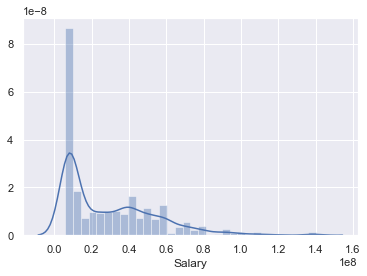

In [211]:
sns.distplot(df['Salary'])

In [5]:
cat_feat = ['Nat', 'Hand', 'Position', 'DftYr', 'DftRd', 'Ovrl']
rem_feat = cat_feat
rem_feat.append('Salary')
# rem_feat
num_feat = list(train_df.drop(cat_feat, axis=1).columns)

In [6]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

300 train examples
100 validation examples
100 test examples


In [7]:
train

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Position,GP,...,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GSG,AgeStart
458,1050000,CAN,76,221,2007.0,3.0,78.0,R,D,38,...,-0.1,2.1,2.0,1544.78,143,16.2,102.3,10.7,0.28,27.570157
252,6000000,CAN,74,211,2009.0,1.0,4.0,L,LW,70,...,4.2,1.0,5.1,2825.59,252,4.5,116.3,41.1,0.59,25.196441
390,742500,USA,75,219,2012.0,2.0,59.0,L,C/LW,1,...,0.0,0.0,-0.1,38.49,1,0.0,122.8,-0.6,-0.59,22.718686
125,3000000,SWE,76,215,2009.0,4.0,102.0,L,D,82,...,0.5,4.1,4.6,2932.08,203,5.8,108.7,38.3,0.47,26.387406
267,2075000,CAN,75,226,2010.0,1.0,21.0,L,C,80,...,-1.5,0.2,-1.2,3362.04,133,16.8,103.4,8.0,0.10,24.848734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,925000,CAN,74,232,2014.0,1.0,10.0,L,LW,77,...,1.9,1.3,3.2,3005.40,335,12.5,112.5,33.1,0.43,20.854209
319,5000000,USA,75,228,2009.0,1.0,19.0,L,LW/C,75,...,5.4,1.4,6.8,2988.29,222,6.2,113.4,59.7,0.80,25.453799
424,4500000,RUS,73,204,2009.0,1.0,14.0,L,D,47,...,-0.5,0.4,-0.1,1744.37,158,6.5,112.1,-2.2,-0.05,25.954825
102,925000,USA,72,177,2014.0,1.0,20.0,R,C/LW,61,...,1.5,1.2,2.7,2469.01,53,22.0,106.8,25.8,0.42,20.635181


In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Salary')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [9]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
train_ds

<BatchDataset shapes: ({Nat: (None,), Ht: (None,), Wt: (None,), DftYr: (None,), DftRd: (None,), Ovrl: (None,), Hand: (None,), Position: (None,), GP: (None,), G: (None,), A: (None,), A1: (None,), A2: (None,), PTS: (None,), plsmin: (None,), Eplsmin: (None,), PIM: (None,), Shifts: (None,), TOI: (None,), TOIX: (None,), TOIGP: (None,), TOIGP1: (None,), TOIperc: (None,), IPPperc: (None,), SHperc: (None,), SVperc: (None,), PDO: (None,), F60: (None,), A60: (None,), Pctperc: (None,), Diff: (None,), Diff60: (None,), iCF: (None,), iCF1: (None,), iFF: (None,), iSF: (None,), iSF1: (None,), iSF2: (None,), ixG: (None,), iSCF: (None,), iRB: (None,), iRS: (None,), iDS: (None,), sDist: (None,), Pass: (None,), iHF: (None,), iHF1: (None,), iHA: (None,), iHDf: (None,), iMiss: (None,), iGVA: (None,), iTKA: (None,), iBLK: (None,), iGVA1: (None,), iTKA1: (None,), iBLK1: (None,), BLKperc: (None,), iFOW: (None,), iFOL: (None,), iFOW1: (None,), iFOL1: (None,), FOperc: (None,), percFOT: (None,), dzFOW: (None,), d

In [11]:
def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

In [12]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of heights:', feature_batch['G'])
  print('A batch of targets:', label_batch )

Every feature: ['Nat', 'Ht', 'Wt', 'DftYr', 'DftRd', 'Ovrl', 'Hand', 'Position', 'GP', 'G', 'A', 'A1', 'A2', 'PTS', 'plsmin', 'Eplsmin', 'PIM', 'Shifts', 'TOI', 'TOIX', 'TOIGP', 'TOIGP1', 'TOIperc', 'IPPperc', 'SHperc', 'SVperc', 'PDO', 'F60', 'A60', 'Pctperc', 'Diff', 'Diff60', 'iCF', 'iCF1', 'iFF', 'iSF', 'iSF1', 'iSF2', 'ixG', 'iSCF', 'iRB', 'iRS', 'iDS', 'sDist', 'Pass', 'iHF', 'iHF1', 'iHA', 'iHDf', 'iMiss', 'iGVA', 'iTKA', 'iBLK', 'iGVA1', 'iTKA1', 'iBLK1', 'BLKperc', 'iFOW', 'iFOL', 'iFOW1', 'iFOL1', 'FOperc', 'percFOT', 'dzFOW', 'dzFOL', 'nzFOW', 'nzFOL', 'ozFOW', 'ozFOL', 'FOWUp', 'FOLUp', 'FOWDown', 'FOLDown', 'FOWClose', 'FOLClose', 'OTG', '1G', 'GWG', 'ENG', 'PSG', 'PSA', 'GBkhd', 'GDflct', 'GSlap', 'GSnap', 'GTip', 'GWrap', 'GWrst', 'CBar', 'Post', 'Over', 'Wide', 'SBkhd', 'SDflct', 'SSlap', 'SSnap', 'STip', 'SWrap', 'SWrst', 'iPenT', 'iPenD', 'iPENT', 'iPEND', 'iPenDf', 'NPD', 'Min', 'Maj', 'Match', 'Misc', 'Game', 'CF', 'CA', 'FF', 'FA', 'SF', 'SA', 'xGF', 'xGA', 'SCF', 

In [13]:
feature_columns = []
for header in num_feat:
  scal_input_fn = get_scal(header)
  feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

In [14]:
for feature_name in cat_feat:
  vocabulary = train_df[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  one_hot = feature_column.indicator_column(cat_c)
  feature_columns.append(one_hot)

In [15]:
feature_columns[0]


NumericColumn(key='Ht', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x0000026B885F01E0>)

In [16]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dropout(0.2),
  
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_fit = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


ValueError: in converted code:
    relative to C:\Users\Pat\Anaconda3\lib\site-packages\tensorflow_core\python\feature_column:

    dense_features.py:133 call
        self._state_manager)
    feature_column_v2.py:4360 get_dense_tensor
        return transformation_cache.get(self, state_manager)
    feature_column_v2.py:2608 get
        transformed = column.transform_feature(self, state_manager)
    feature_column_v2.py:4299 transform_feature
        transformation_cache, state_manager)
    feature_column_v2.py:3774 get_sparse_tensors
        transformation_cache.get(self, state_manager), None)
    feature_column_v2.py:2608 get
        transformed = column.transform_feature(self, state_manager)
    feature_column_v2.py:3751 transform_feature
        transformation_cache.get(self.key, state_manager))
    feature_column_v2.py:2600 get
        raise ValueError('Feature {} is not in features dictionary.'.format(key))

    ValueError: Feature Salary is not in features dictionary.
